In [14]:
# import gradio as gr
# import argparse
import gdown
import cv2
import numpy as np
# from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(sys.path[0]+"/tracker")
sys.path.append(sys.path[0]+"/tracker/model")
# from tools.interact_tools import SamControler
# from tracker.base_tracker import BaseTracker
# from inpainter.base_inpainter import BaseInpainter
from track_anything import TrackingAnything
# from track_anything import parse_augment
import requests
# import json
import torchvision
import torch 
# from tools.painter import mask_painter
import psutil
import time
# try: 
    # from mmcv.cnn import ConvModule
# except:
    # os.system("mim install mmcv")

In [15]:
# download checkpoints
def download_checkpoint(url, folder, filename):
    os.makedirs(folder, exist_ok=True)
    filepath = os.path.join(folder, filename)

    if not os.path.exists(filepath):
        print("download checkpoints ......")
        response = requests.get(url, stream=True)
        with open(filepath, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)

        print("download successfully!")

    return filepath

def download_checkpoint_from_google_drive(file_id, folder, filename):
    os.makedirs(folder, exist_ok=True)
    filepath = os.path.join(folder, filename)

    if not os.path.exists(filepath):
        print("Downloading checkpoints from Google Drive... tips: If you cannot see the progress bar, please try to download it manuall \
              and put it in the checkpointes directory. E2FGVI-HQ-CVPR22.pth: https://github.com/MCG-NKU/E2FGVI(E2FGVI-HQ model)")
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, filepath, quiet=False)
        print("Downloaded successfully!")

    return filepath

In [16]:
# args, defined in track_anything.py
args = {
    'device': 'cuda:0',
    'sam_model_type': 'vit_h',
    'port': 12212,
    'debug': False,
    'mask_save': False
}

# check and download checkpoints if needed
SAM_checkpoint_dict = {
    'vit_h': "sam_vit_h_4b8939.pth",
    'vit_l': "sam_vit_l_0b3195.pth", 
    "vit_b": "sam_vit_b_01ec64.pth"
}
SAM_checkpoint_url_dict = {
    'vit_h': "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
    'vit_l': "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth",
    'vit_b': "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
}
sam_checkpoint = SAM_checkpoint_dict[args['sam_model_type']] 
sam_checkpoint_url = SAM_checkpoint_url_dict[args['sam_model_type']]
xmem_checkpoint = "XMem-s012.pth"
xmem_checkpoint_url = "https://github.com/hkchengrex/XMem/releases/download/v1.0/XMem-s012.pth"
e2fgvi_checkpoint = "E2FGVI-HQ-CVPR22.pth"
e2fgvi_checkpoint_id = "10wGdKSUOie0XmCr8SQ2A2FeDe-mfn5w3"

folder ="../checkpoints"
SAM_checkpoint = download_checkpoint(sam_checkpoint_url, folder, sam_checkpoint)
xmem_checkpoint = download_checkpoint(xmem_checkpoint_url, folder, xmem_checkpoint)
e2fgvi_checkpoint = download_checkpoint_from_google_drive(e2fgvi_checkpoint_id, folder, e2fgvi_checkpoint)

# initialize sam, xmem, e2fgvi models
model = TrackingAnything(SAM_checkpoint, xmem_checkpoint, e2fgvi_checkpoint,args)

Initializing BaseSegmenter to cuda:0
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
load pretrained SPyNet...
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmediting/restorers/basicvsr/spynet_20210409-c6c1bd09.pth


Please specify the path of the video file as "video_path."

In [17]:
# load video
frames = []
video_path = '../test_sample/test-sample2.mp4'
user_name = time.time()

try:
    cap = cv2.VideoCapture(video_path) # Video loading
    fps = cap.get(cv2.CAP_PROP_FPS) # Retrieve the frame rate (FPS) from a video
    while cap.isOpened():  # ret: True if the frame is loaded, frame: 1 frame data
        ret, frame = cap.read()
        if ret == True:
            current_memory_usage = psutil.virtual_memory().percent
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            if current_memory_usage > 90:
                operation_log = [("Memory usage is too high (>90%). Stop the video extraction. Please reduce the video resolution or frame rate.", "Error")]
                print("Memory usage is too high (>90%). Please reduce the video resolution or frame rate.")
                break
        else:
            break
except (OSError, TypeError, ValueError, KeyError, SyntaxError) as e:
    print("read_frame_source:{} error. {}\n".format(video_path, str(e)))
image_size = (frames[0].shape[0],frames[0].shape[1])

video_state = {
    "user_name": user_name,
    "video_name": os.path.split(video_path)[-1],
    "origin_images": frames,
    "painted_images": frames.copy(),
    "masks": [np.zeros((frames[0].shape[0],frames[0].shape[1]), np.uint8)]*len(frames),
    "logits": [None]*len(frames),
    "select_frame_number": 0,
    "fps": fps
}

interactive_state = {
    "inference_times": 0,
    "negative_click_times" : 0,
    "positive_click_times": 0,
    "mask_save": args['mask_save'],
    "multi_mask": {
        "mask_names": [],
        "masks": [],
        "painted_images": [],
    },
    "track_end_number": None,
    "resize_ratio": 1
}

video_info = "Video Name: {}, FPS: {}, Total Frames: {}, Image Size:{}".format(video_state["video_name"], video_state["fps"], len(frames), image_size)
print(video_info)

Video Name: test-sample2.mp4, FPS: 29.97002997002997, Total Frames: 149, Image Size:(320, 568)


Please set the starting frame for tracking as "image_selection_slider."

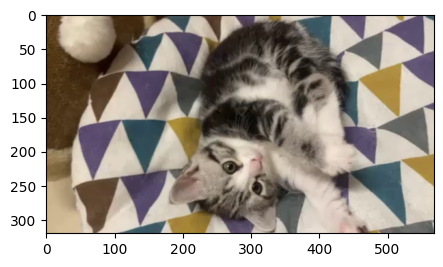

In [18]:
# Selecting the frame to start tracking
image_selection_slider = 0 # Specify a frame arbitrarily
video_state["select_frame_number"] = image_selection_slider
template_frame = video_state["painted_images"][image_selection_slider]
interactive_state["resize_ratio"] = 0.5 # resize ratio

plt.figure(figsize=(5,5))
plt.imshow(template_frame)
plt.axis('on')
plt.show()

Please set the ending frame for tracking as "track_pause_number_slider."

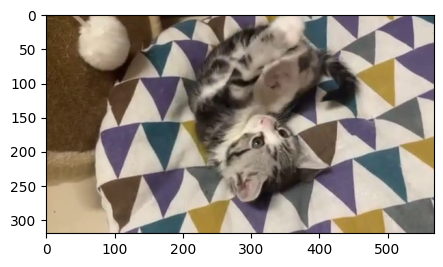

In [19]:
# Selecting the frame to end tracking
track_pause_number_slider = len(frames)-1 # Specify a frame arbitrarily
interactive_state["track_end_number"] = track_pause_number_slider
end_image = video_state["painted_images"][track_pause_number_slider]

plt.figure(figsize=(5,5))
plt.imshow(end_image)
plt.axis('on')
plt.show()

In [20]:
# For visualization
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
# add multi mask
def add_multi_mask(video_state, interactive_state, mask_dropdown):
    mask = video_state["masks"][video_state["select_frame_number"]]
    painted_images = video_state["painted_images"][video_state["select_frame_number"]]
    interactive_state["multi_mask"]["masks"].append(mask)
    interactive_state["multi_mask"]["painted_images"].append(painted_images)
    interactive_state["multi_mask"]["mask_names"].append("mask_{:03d}".format(len(interactive_state["multi_mask"]["masks"])))
    mask_dropdown.append("mask_{:03d}".format(len(interactive_state["multi_mask"]["masks"])))
    return interactive_state, mask_dropdown

Please input the tracking coordinates and labels into "input_point" and "input_label" respectively. Multiple entries are allowed.

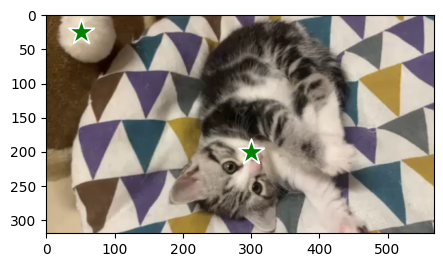

In [21]:
# specifying coordinates
input_point = np.array([[300, 200], [50, 25]])
input_label = np.array([1, 1]) # 0: background, 1: foreground

plt.figure(figsize=(5,5))
plt.imshow(template_frame)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [22]:
# get mask with Segment Anything
def get_mask(video_state, interactive_state, input_point, input_label):
    mask_dropdown = []
    for point, label in zip(input_point, input_label):
        prompt = {
            "prompt_type":["click"],
            "input_point":np.array([point]),
            "input_label":np.array([label]),
            "multimask_output":"True",
        }
        model.samcontroler.sam_controler.reset_image()
        model.samcontroler.sam_controler.set_image(video_state["origin_images"][video_state["select_frame_number"]]) # extracting image features
        mask, logit, painted_image = model.first_frame_click( 
                                        image=video_state["origin_images"][video_state["select_frame_number"]], 
                                        points=prompt["input_point"],
                                        labels=prompt["input_label"],
                                        multimask=prompt["multimask_output"],
                                        )
        video_state["masks"][video_state["select_frame_number"]] = mask
        video_state["logits"][video_state["select_frame_number"]] = logit
        video_state["painted_images"][video_state["select_frame_number"]] = painted_image

        interactive_state, mask_dropdown = add_multi_mask(video_state, interactive_state, mask_dropdown)
    return video_state, interactive_state, mask_dropdown
    
# generate video after vos inference
def generate_video_from_frames(frames, output_path, fps=30):
    """
    Generates a video from a list of frames.
    
    Args:
        frames (list of numpy arrays): The frames to include in the video.
        output_path (str): The path to save the generated video.
        fps (int, optional): The frame rate of the output video. Defaults to 30.
    """
    # height, width, layers = frames[0].shape
    # fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    # video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    # print(output_path)
    # for frame in frames:
    #     video.write(frame)
    
    # video.release()
    frames = torch.from_numpy(np.asarray(frames))
    if not os.path.exists(os.path.dirname(output_path)):
        os.makedirs(os.path.dirname(output_path))
    torchvision.io.write_video(output_path, frames, fps=fps, video_codec="libx264")
    return output_path

In [23]:
# get mask
video_state, interactive_state, mask_dropdown = get_mask(video_state, interactive_state, input_point, input_label)

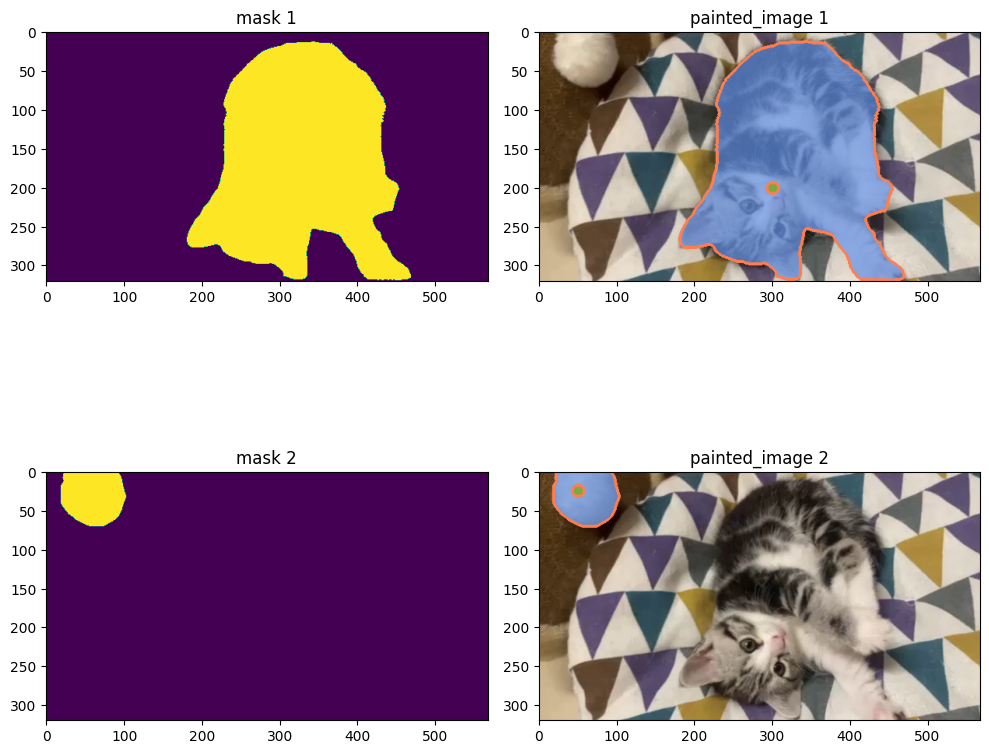

In [24]:
# visualization of masks
masks = interactive_state["multi_mask"]["masks"]
painted_images = interactive_state["multi_mask"]["painted_images"]

fig, axs = plt.subplots(len(masks), 2, figsize=(10, len(masks)*5))
for i in range(len(masks)):
    axs[i, 0].imshow(masks[i])
    axs[i, 0].set_title('mask {}'.format(i+1))
    axs[i, 1].imshow(painted_images[i])
    axs[i, 1].set_title('painted_image {}'.format(i+1))

plt.tight_layout()
plt.show()

In [25]:
# tracking video from select image and mask
model.xmem.clear_memory()

if interactive_state["track_end_number"]:
    following_frames = video_state["origin_images"][video_state["select_frame_number"]:interactive_state["track_end_number"]]
else:
    following_frames = video_state["origin_images"][video_state["select_frame_number"]:]

if interactive_state["multi_mask"]["masks"]:
    if len(mask_dropdown) == 0:
        mask_dropdown = ["mask_001"]
    mask_dropdown.sort()
    template_mask = interactive_state["multi_mask"]["masks"][int(mask_dropdown[0].split("_")[1]) - 1] * (int(mask_dropdown[0].split("_")[1]))
    for i in range(1,len(mask_dropdown)):
        mask_number = int(mask_dropdown[i].split("_")[1]) - 1 
        template_mask = np.clip(template_mask+interactive_state["multi_mask"]["masks"][mask_number]*(mask_number+1), 0, mask_number+1)
    video_state["masks"][video_state["select_frame_number"]]= template_mask
else:      
    template_mask = video_state["masks"][video_state["select_frame_number"]]
fps = video_state["fps"]
# operation error
if len(np.unique(template_mask))==1:
    template_mask[0][0]=1
    operation_log = [("Error! Please add at least one mask to track by clicking the left image.","Error"), ("","")]
    # return video_output, video_state, interactive_state, operation_error
masks, logits, painted_images = model.generator(images=following_frames, template_mask=template_mask)
# clear GPU memory
model.xmem.clear_memory()

if interactive_state["track_end_number"]: 
    video_state["masks"][video_state["select_frame_number"]:interactive_state["track_end_number"]] = masks
    video_state["logits"][video_state["select_frame_number"]:interactive_state["track_end_number"]] = logits
    video_state["painted_images"][video_state["select_frame_number"]:interactive_state["track_end_number"]] = painted_images
else:
    video_state["masks"][video_state["select_frame_number"]:] = masks
    video_state["logits"][video_state["select_frame_number"]:] = logits
    video_state["painted_images"][video_state["select_frame_number"]:] = painted_images

video_output = generate_video_from_frames(video_state["painted_images"], output_path="./result/track/{}".format(video_state["video_name"]), fps=fps) # import video_input to name the output video
interactive_state["inference_times"] += 1

#### shanggao code for mask save
if interactive_state["mask_save"]:
    if not os.path.exists('./result/mask/{}'.format(video_state["video_name"].split('.')[0])):
        os.makedirs('./result/mask/{}'.format(video_state["video_name"].split('.')[0]))
    i = 0
    print("save mask")
    for mask in video_state["masks"]:
        np.save(os.path.join('./result/mask/{}'.format(video_state["video_name"].split('.')[0]), '{:05d}.npy'.format(i)), mask)
        i+=1

Tracking image: 100%|██████████| 148/148 [00:03<00:00, 42.51it/s]


In [1]:
# display Video
from IPython.display import Video

Video("./result/track/test-sample2.mp4")